# Load libraries

In [2]:
import cv2
import numpy as np
import random # for coloring the recognized, grouped together lines with different colors (to distinquish that we don't combine lines incorrectly)
from skimage import io
import matplotlib.pyplot as plt # for visualization

The task was to recognize circles from an image like this, and to count the number of lines inside each circle. Intersecting lines were to be counter separately. Since the lines are hand-drawn and the circles are irregular and not perfect, some advanced detection methods are required.

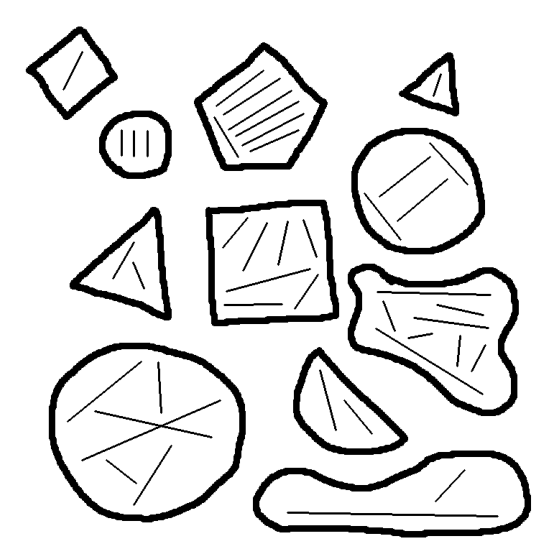

In [4]:
def read_image(image_path, grayscale=False):
    """ Read the input image, and process it as 1-channel (grayscale) tai 3-channel (RGB)"""
    try:
        if grayscale:
            img = io.imread(image_path, as_gray=True)
            img = (img * 255).astype(np.uint8) # skimage outputs images as floats in scale [0, 1], so reconvert it to [0, 255] and int8
        else:
            img = io.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # skimage outputs the color image as RGB, but OpenCV wants it as BGR-channel
        return img
    except FileNotFoundError:
        print(f"Error: Image is not in readable format or there is no image at {image_path}")
        return None

input_image_path = "CV-circle-lines.png"
input_image = read_image(input_image_path)

# visualize img
plt.figure(figsize=(7, 7))
plt.imshow(input_image)
plt.axis('off')
plt.show()

# First, detect simple circular shapes

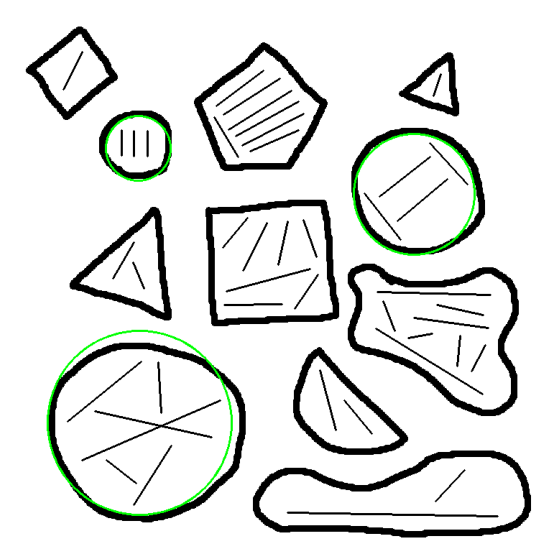

In [5]:
def detect_circles(img):
    """ Detection algorithm for circular shapes with OpenCV's HoughCirclesf-fitting"""
    if img is None:
        return None

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    img_blur = cv2.GaussianBlur(img_gray, (9, 9), 2) # add gaussian blur to reduce noise in shapes and enhance main components
    
    circles = cv2.HoughCircles(
        img_blur,
        cv2.HOUGH_GRADIENT,
        dp=1, # resolution, 1 == no change
        minDist=300, # min distance between the center points of recognized circles
        param1=60, # upper limit for the canny edge detection algorithm
        param2=55, # threshold value for circle centers
        minRadius=10,
        maxRadius=150
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0, :]
    else:
        return None

def detect_circles_and_visualize(image):
    """ visualize the recognized houghcircles"""
    if image is None:
        return None

    circles = detect_circles(image)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles: # loop trough the detected circles
            center = (i[0], i[1])
            radius = i[2]
            cv2.circle(image, center, radius, (0, 255, 0), 2)  # draw the circles with green

        return image
    else:
        print(" No circles detected.")
        return image

visualize_circles = detect_circles_and_visualize(input_image)

# visualize img
plt.figure(figsize=(7, 7))
plt.imshow(visualize_circles)
plt.axis('off')
plt.show()

# Fit the recognized circular shapes to circle countours from the inner arch, so that we can correctly detect the shape of real, irregular circle and the lines that fall inside it. This way we can make sure that the lines detected from the circle countour itself wont be counted as lines

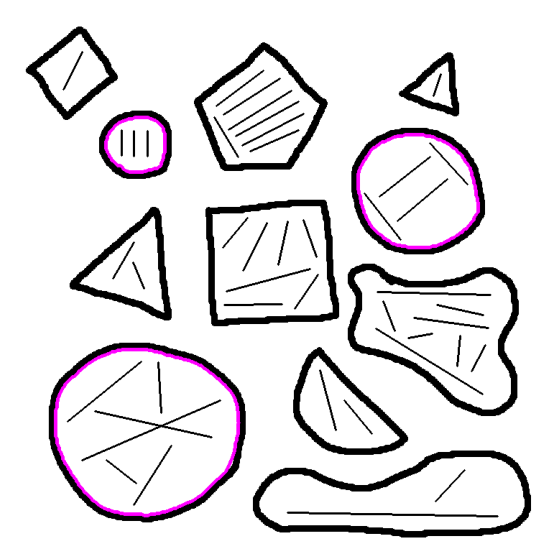

In [6]:
def detect_circles_and_visualize_irregular(image):
    """ visualize the recognized houghcircles and fit the outlines to the inner arcs"""
    if image is None:
        return None

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    circles = detect_circles(image)

    if circles is not None:
        for i in circles: # loop trough circles
            center = (i[0], i[1])
            radius = i[2]

            # masking
            mask = np.zeros_like(img_gray, dtype=np.uint8) # create the mask
            cv2.circle(mask, center, radius + 10, 255, -1) # draw a white circle, which is a little (10px) bigger than the recognized circle on the mask
            masked_img = cv2.bitwise_and(img_gray, img_gray, mask=mask) # apply the resulting mask on the image to focus on the area around the circle

            # find the circle contours
            cnts = cv2.findContours(masked_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find contours and outlines from the masked area
            cnts = cnts[0] if len(cnts) == 2 else cnts[1] # depending on the OpenCV version, contours can be 1st (v4 onward) or 2nd (v3) element
            if cnts:
                cnt = max(cnts, key=cv2.contourArea) # choose contours with the largest area
                cv2.drawContours(image, [cnt], -1, (255, 0, 255), 3)  # draw on the input img

        return image
    else:
        print(" No circles detected.")
        return image

input_image_irregular = read_image(input_image_path) # load a new input image, otherwise will overwrite the previous one
circles_visualize_irregular = detect_circles_and_visualize_irregular(input_image_irregular)

# visualize img
plt.figure(figsize=(7, 7))
plt.imshow(circles_visualize_irregular)
plt.axis('off')
plt.show()

# Helper functions

In [7]:
def check_line_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    """ checks, whether two lines intersect"""
    def orientation(p, q, r):
        """ calculates the orientation of a line with three points (p, q, r)"""
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

        if val == 0:
            return 0  # colinear, i.e. the points are on the same line
        return 1 if val > 0 else 2  # clockwise if "val > 0", counterclockwise if "val < 0"

    # check the general case, i.e. intersects at one point
    o1 = orientation((x1, y1), (x2, y2), (x3, y3))
    o2 = orientation((x1, y1), (x2, y2), (x4, y4))
    o3 = orientation((x3, y3), (x4, y4), (x1, y1))
    o4 = orientation((x3, y3), (x4, y4), (x2, y2))

    if o1 != o2 and o3 != o4: # if the orientations differ, the lines would eventually intersect
        return True

    # check for colinearity and whether the segments touch
    if o1 == 0 and on_segment((x1, y1), (x3, y3), (x2, y2)): # is (x3,y3) in line segment (x1,y1)-(x2,y2) and colinear
        return True
    if o2 == 0 and on_segment((x1, y1), (x4, y4), (x2, y2)):
        return True
    if o3 == 0 and on_segment((x3, y3), (x1, y1), (x4, y4)):
        return True
    if o4 == 0 and on_segment((x3, y3), (x2, y2), (x4, y4)):
        return True

    return False # no intersection

def on_segment(p, q, r):
    """ check, whether point q in segment pr"""
    if (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and \
       (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1])): # are q's coordinates in p's ja r's segment
        return True
    return False

def fit_line_to_points(points):
    """ fit the line to recognized points for visualization purposes"""
    x_coords, y_coords = zip(*points)  # divide the tuple into coordinate lists
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T # create a matrix
    m, c = np.linalg.lstsq(A, y_coords, rcond=None)[0]  # linear regression to find the slope and intersection

    # find the end points for the fitted line
    x1 = min(x_coords) 
    y1 = int(m * x1 + c) # calculate y with equation "y = mx + c"
    x2 = max(x_coords)
    y2 = int(m * x2 + c)

    return x1, y1, x2, y2

# Final line counting inside the circles

Circle Data (x, y, radius, line_count):
{'x': 562, 'y': 256, 'radius': 84, 'line_count': 4}
{'x': 180, 'y': 574, 'radius': 128, 'line_count': 6}
{'x': 178, 'y': 192, 'radius': 45, 'line_count': 3}


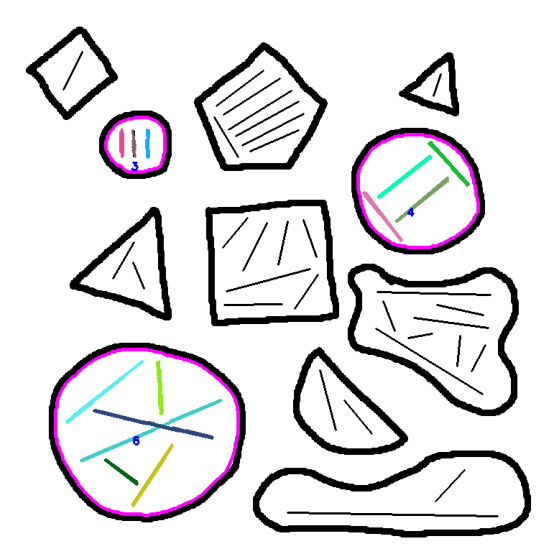

In [8]:
def detect_lines_in_circles(image, circles):
    """ detect and visualize lines inside the recognized circles"""
    if image is None:
        return None, None

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
    img_blur_thresh = cv2.GaussianBlur(img_gray, (5, 5), 2) # add gaussian blur to reduce noise in shapes and enhance main components
    thresh = cv2.adaptiveThreshold(img_blur_thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2) # find shapes with adaptive threshold. With the adaptivity we can take the local area's features into account
    
    circle_data = [] # collect circle data for printing

    if circles is not None:
        for i in circles: 
            center = (i[0], i[1])
            radius = i[2]

            min_line_length = int(radius * 0.2) # define the minimum lenght for a line in respect to the circle size to be recognized 
            max_line_gap = int(radius * 0.05) # define the maximum distance between points for a line to still be counted as the same line
            threshold = 30

            lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=threshold,
                                    minLineLength=min_line_length, maxLineGap=max_line_gap) # recognize lines with propabilistic HoughLinesP

            # masking
            mask = np.zeros_like(img_gray, dtype=np.uint8) # create mask
            cv2.circle(mask, center, radius + 10, 255, -1) # draw a white circle on the mask, which is a bit larger than the recognized circle
            masked_img = cv2.bitwise_and(img_gray, img_gray, mask=mask) # apply the mask to encircle the circle and surrounding area
            
            cnts = cv2.findContours(masked_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find contours and outlines from the masked area
            cnts = cnts[0] if len(cnts) == 2 else cnts[1] # depending on the OpenCV:n versin, contours might be the 1st (v4) or 2nd (v3) element
            cnt = max(cnts, key=cv2.contourArea) # choose the contours with the largest area

            line_count = 0 # for counting the number of lines in the circle
            if lines is not None:
                grouped_lines = [] # list to combine lines
                for line in lines:
                    x1, y1, x2, y2 = line[0] # find line's outermost points
                    pt1 = (float(x1), float(y1))
                    pt2 = (float(x2), float(y2))

                    if cv2.pointPolygonTest(cnt, pt1, False) >= 0 and cv2.pointPolygonTest(cnt, pt2, False) >= 0: # check whether both outermost points are within the recognized circle
                        added_to_group = False # already added to the group?
                        for group in grouped_lines:
                            for line2 in group: 
                                x3, y3, x4, y4 = line2[0] # take the outermost points of a line in the group

                                # calculate the distance between the outermost points (helps in defining whether they are partial lines of the same line)
                                dist1_3 = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
                                dist1_4 = np.sqrt((x1 - x4) ** 2 + (y1 - y4) ** 2)
                                dist2_3 = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
                                dist2_4 = np.sqrt((x2 - x4) ** 2 + (y2 - y4) ** 2)

                                if (dist1_3 < 10 or dist1_4 < 10 or dist2_3 < 10 or dist2_4 < 10): # check, if the (partial) lines are close enough to be combined
                                    group.append(line) # add a line to the group
                                    added_to_group = True
                                    break
                            if added_to_group:
                                break
                        if not added_to_group:
                            grouped_lines.append([line]) # new group for a line



                # visualize the lines before merging, since the visualization will otherwise not always align with the actual line, even when the line count is the same
                for group in grouped_lines: # loop line groups
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # roll a random color for different lines; helps in recognizing that the detection and line merging works as intended
                    for line in group:
                        x1, y1, x2, y2 = line[0] # lines outermost points
                        cv2.line(image, (x1, y1), (x2, y2), color, 2) # draw the line with randomized color

                # merging the lines and more exact counting
                final_lines = [] # final, merged lines
                merged_indices = set() # set to keep track of merged lines
                for i in range(len(grouped_lines)):
                    if i in merged_indices: 
                        continue  # skip already merged

                    group1 = grouped_lines[i] # 1st group
                    x1_1, y1_1, x2_1, y2_1 = group1[0][0] # outermost points
                    final_group = [group1] # initialize the final group

                    for j in range(i + 1, len(grouped_lines)): # loop trough the remaining line groups
                        if j in merged_indices:
                            continue

                        group2 = grouped_lines[j]
                        x1_2, y1_2, x2_2, y2_2 = group2[0][0]

                        angle1 = np.arctan2(y2_1 - y1_1, x2_1 - x1_1) # angle of 1st line
                        angle2 = np.arctan2(y2_2 - y1_2, x2_2 - x1_2) # angle of 2nd line
                        angle_diff = abs(angle1 - angle2) # angle difference
                        if angle_diff > np.pi:
                            angle_diff = 2 * np.pi - angle_diff

                        intersects = check_line_intersection(x1_1, y1_1, x2_1, y2_1, x1_2, y1_2, x2_2, y2_2) # check, whether the lines intersect

                        if intersects and angle_diff < np.pi / 4: # if intersects and the angle difference is small, consider them to be part of the same line (as without this we would have a lot of very small lines)
                            final_group.append(group2) # add to the group
                            merged_indices.add(j) # mark as merged


                    # combine lines with linear regression
                    combined_points = [] # list for combined points
                    for group in final_group:
                        for line in group:
                            combined_points.append((line[0][0], line[0][1])) # add the outermost points to the list
                            combined_points.append((line[0][2], line[0][3]))

                    final_x1, final_y1, final_x2, final_y2 = fit_line_to_points(combined_points) # fit the line to the combined points
                    final_lines.append([(final_x1, final_y1, final_x2, final_y2)]) # add the fitted line to the final list

                line_count = len(final_lines) # update the line count

            """for line in final_lines: # visualizes the merged lines, which i used to check that the counting works as intended. it will just sometimes not visualize the line on the actual line
                 x1, y1, x2, y2 = line[0]
                 color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                 cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)"""

            cv2.drawContours(image, [cnt], -1, (255, 0, 255), 3) # draw the circle outlines
            cv2.putText(image, str(line_count), (center[0] - 10, center[1] + 30), # write the line count on the image
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            circle_data.append({"x": center[0], "y": center[1], "radius": radius, "line_count": line_count}) # print the data

        return image, circle_data
    else:
        return image, None

final_image = read_image(input_image_path)
circles = detect_circles(final_image)
result_image, circle_data = detect_lines_in_circles(final_image, circles)

# print the circle coordinates, radius and its line count
if circle_data is not None:
    print("Circle Data (x, y, radius, line_count):")
    for circle in circle_data:
        print(circle)

# visualize image
plt.figure(figsize=(7, 7))
plt.imshow(result_image)
plt.axis('off')
plt.show()